In [1]:
from xtr_via_plaid import search, XTRRunConfig
from evaluation.evaluate_lotte_rankings import evaluate_dataset

In [2]:
def make_config(collection, datasplit, nbits, k):
    return XTRRunConfig(nranks=4, dataset="lotte", collection=collection,
                    type_="search", datasplit=datasplit, nbits=nbits, k=k)

COLLECTIONS = ["lifestyle", "pooled", "recreation", "science", "technology", "writing"]
DATASPLITS = ["dev", "test"]
NBITS = [1, 2, 4]
K = [100]

### Evaluate Accuracy (XTR/PLAID)

In [5]:
import itertools
from tqdm import tqdm
import json
import os

if not os.path.exists("results.json"):
    results = []
    for collection, split, nbits, k in tqdm(itertools.product(COLLECTIONS, DATASPLITS, NBITS, K)):
        config = make_config(collection=collection, datasplit=split, nbits=nbits, k=k)
        rankings_path = search(config)
    
        # NOTE For now always (just) evaluate S@5
        result = evaluate_dataset(rankings_path, collection, split, k=5)
        result['config'] = {'collection': collection, 'split': split, 'nbits': nbits, 'k': k}
        results.append(result)
    
    with open("results.json", "w") as file:
        file.write(json.dumps(results))
else:
    with open("results.json", "r") as file:
        results = json.loads(file.read())

In [59]:
import pandas as pd

xtr_base = {"lifestyle": 82.1, "pooled": 69.0, "recreation":69.4, "science": 54.9, "technology": 63.2, "writing": 77.0}
xtr_xxl = {"lifestyle": 89.1, "pooled": 77.3, "recreation": 79.3, "science": 60.8, "technology": 73.7, "writing": 83.3}
colbert = {"lifestyle": 80.2, "pooled": 67.3, "recreation": 68.5, "science": 53.6, "technology": 61.9, "writing": 74.7}
colbertv2 = {"lifestyle": 84.7, "pooled": 71.6, "recreation": 72.3, "science": 56.7, "technology": 66.1, "writing": 80.1}

results_by_dataset = dict()
offset = dict()
for result in results:
    collection = result["provenance"]["dataset"]
    nbits = result["config"]["nbits"]
    
    s5 = result["metrics"]["Success@5"]
    results_by_dataset[(collection, nbits)] = round(s5 * 100.0, 1)
    offset_to_base = round(100.0 * s5 - xtr_base[collection], 1)
    if offset_to_base > 0:
        offset_to_base = f"<span style='color:green'>+ {offset_to_base}</span>"
    else:
        offset_to_base = f"<span style='color:red'>{offset_to_base}</span>"
    offset[(collection, nbits)] = offset_to_base

df = pd.DataFrame(data=[[collection, xtr_base[collection], xtr_xxl[collection], *[f"{results_by_dataset[(collection, nbits)]} ({offset[(collection, nbits)]})" for nbits in NBITS], colbert[collection], colbertv2[collection]] for collection in COLLECTIONS],
                  columns=["dataset", "XTR-base", "XTR-xxl", *[f"S@5 (nbits={nbits})" for nbits in NBITS], "ColBERT", "ColBERTv2"])

from IPython.display import display, HTML
display(HTML(df.to_html(escape=False)))

,dataset,XTR-base,XTR-xxl,S@5 (nbits=1),S@5 (nbits=2),S@5 (nbits=4),ColBERT,ColBERTv2
0,lifestyle,82.1,89.1,81.1 (+ -1.0),83.2 (+ 1.1),82.9 (+ 0.8),80.2,84.7
1,pooled,69.0,77.3,65.4 (+ -3.6),68.3 (+ -0.7),69.2 (+ 0.2),67.3,71.6
2,recreation,69.4,79.3,66.5 (+ -2.9),68.6 (+ -0.8),68.6 (+ -0.8),68.5,72.3
3,science,54.9,60.8,52.5 (+ -2.4),54.8 (+ -0.1),56.2 (+ 1.3),53.6,56.7
4,technology,63.2,73.7,60.2 (+ -3.0),62.4 (+ -0.8),63.8 (+ 0.6),61.9,66.1
5,writing,77.0,83.3,76.7 (+ -0.3),77.5 (+ 0.5),77.4 (+ 0.4),74.7,80.1


### Evaluate Latency (XTR/PLAID)

In [1]:
# NOTE Ensure to RESTART the Kernel before running this cell.
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from xtr_via_plaid import search, XTRRunConfig

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


In [4]:
import torch

def setup_num_threads(num_threads):
    torch.set_num_threads(num_threads)
    assert os.environ["CUDA_VISIBLE_DEVICES"] == ""

def make_config(collection, datasplit, nbits, k):
    return XTRRunConfig(nranks=4, dataset="lotte", collection=collection,
                    type_="search", datasplit=datasplit, nbits=nbits, k=k)

COLLECTIONS = ["lifestyle", "pooled", "recreation", "science", "technology", "writing"]
DATASPLITS = ["dev", "test"]
NBITS = [1, 2, 4]
K = [100]
THREADS = [1, 4, 8, 16, 24]

In [5]:
from colbert.modeling.colbert import ColBERT
ColBERT.try_load_torch_extensions(use_gpu=False)

In [11]:
from xtr_via_plaid import search
import itertools
from tqdm import tqdm
import json

root_dir = "latency/xtr"
os.makedirs(root_dir, exist_ok=True)

for collection, split, nbits, k, threads in itertools.product(COLLECTIONS, DATASPLITS, NBITS, K, THREADS):
    filename = f"{collection}_split={split}_nbits={nbits}_k={k}_threads={threads}.json"
    if os.path.exists(os.path.join(root_dir, filename)):
        print(f"Skipping: {collection} {split} {nbits} {k} {threads}")
        continue
    setup_num_threads(threads)
    config = make_config(collection=collection, datasplit=split, nbits=nbits, k=k)
    tracker = search(config, batch_queries=False)

    result = {'config': {'collection': collection, 'split': split, 'nbits': nbits, 'k': k}}
    result['tracker'] = tracker.as_dict()
    # Note "hacky" way to change the name of the tracker
    result['tracker']['name'] = f"XTR/PLAID [baseline, {collection} ({split}, nbits={nbits}), k={k}, threads={threads}]"

    with open(os.path.join(root_dir, filename), "w") as file:
        file.write(json.dumps(result))

[May 29, 17:51:40] #> Loading collection...
0M 
[May 29, 17:51:43] #> Loading codec...
[May 29, 17:51:43] #> Loading IVF...
[May 29, 17:51:43] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 358.06it/s]

[May 29, 17:51:43] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  9.92it/s]

[May 29, 17:51:44] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 17:51:44] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [02:44<00:00,  2.53it/s]


[May 29, 17:54:29] #> Loading collection...
0M 
[May 29, 17:54:31] #> Loading codec...
[May 29, 17:54:31] #> Loading IVF...
[May 29, 17:54:31] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 347.68it/s]

[May 29, 17:54:31] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 15.32it/s]

[May 29, 17:54:32] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 17:54:32] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [01:09<00:00,  6.03it/s]


[May 29, 17:55:41] #> Loading collection...
0M 
[May 29, 17:55:43] #> Loading codec...
[May 29, 17:55:43] #> Loading IVF...
[May 29, 17:55:43] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 381.93it/s]

[May 29, 17:55:43] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 16.88it/s]

[May 29, 17:55:44] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 17:55:44] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:49<00:00,  8.50it/s]


[May 29, 17:56:33] #> Loading collection...
0M 
[May 29, 17:56:35] #> Loading codec...
[May 29, 17:56:35] #> Loading IVF...
[May 29, 17:56:35] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 385.76it/s]

[May 29, 17:56:35] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 18.44it/s]

[May 29, 17:56:36] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 17:56:36] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:37<00:00, 11.10it/s]


[May 29, 17:57:14] #> Loading collection...
0M 
[May 29, 17:57:16] #> Loading codec...
[May 29, 17:57:16] #> Loading IVF...
[May 29, 17:57:16] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 887.09it/s]

[May 29, 17:57:16] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 17.74it/s]

[May 29, 17:57:17] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 17:57:17] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:33<00:00, 12.46it/s]


[May 29, 17:57:50] #> Loading collection...
0M 
[May 29, 17:57:52] #> Loading codec...
[May 29, 17:57:52] #> Loading IVF...
[May 29, 17:57:52] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 353.09it/s]

[May 29, 17:57:52] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.54it/s]

[May 29, 17:57:55] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 17:57:55] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [02:42<00:00,  2.56it/s]


[May 29, 18:00:38] #> Loading collection...
0M 
[May 29, 18:00:40] #> Loading codec...
[May 29, 18:00:40] #> Loading IVF...
[May 29, 18:00:40] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 357.34it/s]

[May 29, 18:00:40] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.66it/s]

[May 29, 18:00:41] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 18:00:41] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [01:09<00:00,  5.97it/s]


[May 29, 18:01:52] #> Loading collection...
0M 
[May 29, 18:01:53] #> Loading codec...
[May 29, 18:01:53] #> Loading IVF...
[May 29, 18:01:53] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 376.19it/s]

[May 29, 18:01:53] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.61it/s]

[May 29, 18:01:55] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 18:01:55] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:48<00:00,  8.57it/s]


[May 29, 18:02:44] #> Loading collection...
0M 
[May 29, 18:02:46] #> Loading codec...
[May 29, 18:02:46] #> Loading IVF...
[May 29, 18:02:46] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 465.85it/s]

[May 29, 18:02:46] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.15it/s]

[May 29, 18:02:48] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 18:02:48] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:37<00:00, 11.25it/s]


[May 29, 18:03:25] #> Loading collection...
0M 
[May 29, 18:03:29] #> Loading codec...
[May 29, 18:03:29] #> Loading IVF...
[May 29, 18:03:29] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 429.48it/s]

[May 29, 18:03:29] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00, 10.63it/s]

[May 29, 18:03:30] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 18:03:30] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:35<00:00, 11.81it/s]


[May 29, 18:04:05] #> Loading collection...
0M 
[May 29, 18:04:07] #> Loading codec...
[May 29, 18:04:07] #> Loading IVF...
[May 29, 18:04:07] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 329.17it/s]

[May 29, 18:04:07] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:03<00:00,  3.15it/s]

[May 29, 18:04:11] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 18:04:11] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [02:43<00:00,  2.55it/s]


[May 29, 18:06:56] #> Loading collection...
0M 
[May 29, 18:06:59] #> Loading codec...
[May 29, 18:06:59] #> Loading IVF...
[May 29, 18:06:59] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 313.13it/s]

[May 29, 18:06:59] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.82it/s]

[May 29, 18:07:01] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 18:07:01] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [01:11<00:00,  5.80it/s]


[May 29, 18:08:14] #> Loading collection...
0M 
[May 29, 18:08:16] #> Loading codec...
[May 29, 18:08:16] #> Loading IVF...
[May 29, 18:08:16] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 286.06it/s]

[May 29, 18:08:16] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.25it/s]

[May 29, 18:08:18] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 18:08:18] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:49<00:00,  8.35it/s]


[May 29, 18:09:09] #> Loading collection...
0M 
[May 29, 18:09:10] #> Loading codec...
[May 29, 18:09:10] #> Loading IVF...
[May 29, 18:09:11] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 373.92it/s]

[May 29, 18:09:11] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  5.80it/s]

[May 29, 18:09:12] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 18:09:12] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:38<00:00, 10.72it/s]


[May 29, 18:09:52] #> Loading collection...
0M 
[May 29, 18:09:54] #> Loading codec...
[May 29, 18:09:54] #> Loading IVF...
[May 29, 18:09:54] #> Loading doclens...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 665.18it/s]

[May 29, 18:09:54] #> Loading codes and residuals...



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.00it/s]

[May 29, 18:09:56] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/dev/questions.search.tsv ...
[May 29, 18:09:56] #> Got 417 queries. All QIDs are unique.




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 417/417 [00:35<00:00, 11.83it/s]


[May 29, 18:10:31] #> Loading collection...
0M 
[May 29, 18:10:33] #> Loading codec...
[May 29, 18:10:33] #> Loading IVF...
[May 29, 18:10:33] #> Loading doclens...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 248.60it/s]

[May 29, 18:10:33] #> Loading codes and residuals...



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.33it/s]

[May 29, 18:10:33] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/test/questions.search.tsv ...
[May 29, 18:10:33] #> Got 661 queries. All QIDs are unique.




 52%|█████████████████████████████████████████████████████████████████▌                                                             | 341/661 [01:37<01:31,  3.50it/s]


KeyboardInterrupt: 

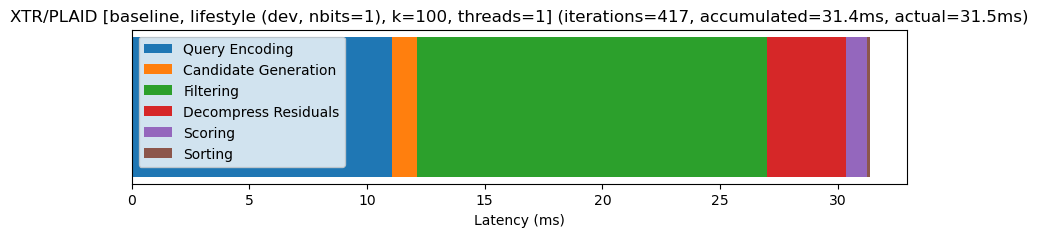

In [5]:
from colbert.utils.tracker import ExecutionTracker

ExecutionTracker.from_dict(results[0]["tracker"]).display()